# CAPSTONE 3. Predicting Major Cryptocurrencies Prices
## Modeling

In this notebook we will continue to implement different times series forecasting algorithms in order to predict Bitcoin price. In particular, we will build two models:
<ul>
    <i>pmdarima</i> - an automated version of ARIMA model that we used in the previous notebook<br>
    <i>Prophet</i> - a time-series forecasting model developped by Facebook<br>
    <i>PyCaret</i> - a Python version of the Caret machine learning package in R<br>
    <i>Exponential Smoothing</i> - a time series forecasting method for univariate data, which can be used as an alternative for ARIMA family of methods<br>
</ul>
As always, we will train the models on the training set and evaluate them on the test set. The train and test sets will be the same that we used in the previous notebook.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import warnings
import datetime as dt
import os
import pickle
from sklearn.metrics import r2_score, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

#setting figure's default size
sns.set(rc={'figure.figsize':(12,5)})
plt.rcParams['figure.figsize'] = (12,5)

sns.set_style('whitegrid')

pd.options.display.float_format = "{:.3f}".format

ModuleNotFoundError: No module named 'pmdarima'

In [2]:
import sys
sys.executable

'D:\\anaconda3\\python.exe'

In [5]:
for p in sys.path:
    print(p)

D:\Prog\SDST\My Projects\Capstone3\MOD
D:\anaconda3\python38.zip
D:\anaconda3\DLLs
D:\anaconda3\lib
D:\anaconda3

D:\anaconda3\lib\site-packages
D:\anaconda3\lib\site-packages\locket-0.2.1-py3.8.egg
D:\anaconda3\lib\site-packages\win32
D:\anaconda3\lib\site-packages\win32\lib
D:\anaconda3\lib\site-packages\Pythonwin
D:\anaconda3\lib\site-packages\IPython\extensions
C:\Users\user\.ipython


### pmdarima

pmdarima is essentially the same Auto Regressive Integrated Moving Average model we built in the previous step. However, there is one difference. If for ARIMA model we used ACF and PACF to determine which order is better to use, pmdarima does it automatically.<br><br>
Let's import the saved files from the previous step. Both train and test sets were scaled in the previous notebook.

In [2]:
df = pd.read_pickle('../PTDD/df.pkl')
train = np.load('../PTDD/train_norm.npy')
test = np.load('../PTDD/test_norm.npy')
btc = pd.read_pickle('../EDA/btc.pkl')

In [3]:
print(len(train))
print(len(test))

1964
30


And take a look once again at BTC price time series.

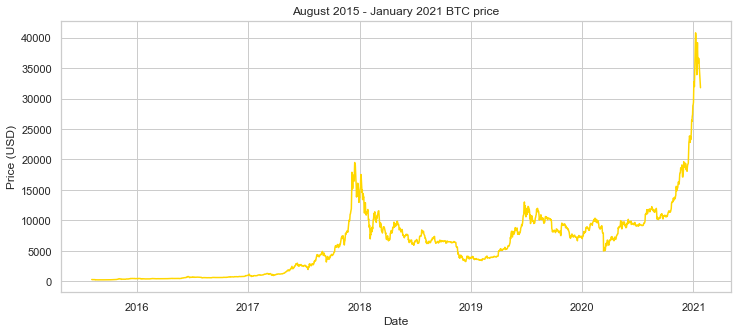

In [4]:
sns.lineplot(data=btc, x='Date', y='Close', color='Gold')
plt.title(f'August 2015 - January 2021 BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

Even though we already know that this time series is not stationary, we will use pmdarima ADFTest() function just to make sure of it once again. This function performs Augmented Dickey-Fuller Test (return False means we will need to perform differencing).

In [5]:
btc_adf_test = pm.arima.ADFTest(alpha=0.05)
btc_adf_test.should_diff(btc['Close'])

NameError: name 'pm' is not defined

The result indicates that our time series is indeed *not* stationary and we will need to use Integrated(d) concept. Next, we will implement the auto_arima() function to build the model. It takes quite a few arguments, but most important for us are:<br>
<ul> 
    <i>p, d, q</i> - they represent non-seasonal components<br>
    <i>P, D, Q</i> - they represent seasonal components<br>
    <i>n_fits</i> - number of iterations that will be performed
</ul><br>
Basically, auto_arima() does kind of a grid search - it iterates over the data and fits the model with different parameters in order to find one with lowest AIC.<br>

#### NOTE:

AIC (Akaike Information Criterion) is a probabilistic model selection method. Without going too deep into the details, it's important to know that AIC penalizes complex models less, thus allowing to focus more on model's performance (even though the model will be more complex). <br><br>
Now let's fit the model on the training set.<br>
#### My laptop, however, has its own memory limitations, so I will have to refrain some parameters to meet those limitations.

In [ ]:
btc_pmdarima = pm.arima.auto_arima(train, start_p=0,d=1,start_q=0, max_p=3,max_d=3,max_q=3, start_P=0,
          D=1, start_Q=3, max_P=3, max_D=3, max_Q=3, seasonal=True, trace=True, stepwise=True,
          random_state=42, n_fits=50)

# Какой использовать m? Написать здесь о результатах. Что значит AIC -12187 и почему он лучше чем первый AIC, который меньше?

In [ ]:
Now we will evaluate the model on the test set.

In [ ]:
btc_pmdarima_predictions = pd.DataFrame(btc_pmdarima.predict(n_periods=30))
btc_pmdarima_predictions.columns = ['predicted']

In [ ]:
plt.plot(test, label='Expected')
plt.plot(btc_pmdarima_predictions, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title('Test set predicted vs expected values for pmdarima')
plt.show()

In [ ]:
r2 = r2_score(test, btc_pmdarima_predictions)
print(f'Test set r-squared for pmdrima is: {round(r2, 2)}')
mepe = mean_absolute_percentage_error(test, btc_pmdarima_predictions)
print(f'Test set MAPE for pmdarima is: {round(mepe,2) * 100}%')

The results, as we see, are terrible. We even got negative r-squared, which probably means that the parameters were calculated incorrectly. Our model was unable to catch the structure and performed poorly. As I mentioned above, the cause for that might be my laptop's memory limitations (inability to allocate enough memory) which did not allow for a full cycle of parameter tuning.<br>
ARIMA(2,1,1) that we built as our baseline model in the previous notebook showed significanty better results.